# Пропущенные значения в данных
Когда в данных есть пропущенные значения, невозможно найти параметры модели. Поэтому необходимо обработать пропущенные значения. Методы делятся на две основные группы:
- для [удаления данных](#удаление-данных) и
- [заполнения данных](#заполнение-данных).

Мы загружаем необходимые пакеты и набор данных:


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 3)
sb.set(font_scale=1.)

In [2]:
df = pd.read_csv('data/missing_data_housing.csv', sep=',')
df.head()

,price,lotsize(m^2),bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,74700,NaN,3,1,1.0,1,1,1,0,0,2,1
1,85000,652.4388,3,1,NaN,1,0,1,0,1,2,1
2,68500,NaN,3,1,2.0,1,0,1,0,0,0,0
3,82900,650.5800,3,1,1.0,1,0,1,0,0,2,1
4,86000,641.2860,3,2,NaN,1,1,1,0,0,0,1


In [3]:
def check_for_missing_values(df): 
    '''Находит отсутствующие значения и возвращает их количество (ненулевые) и процентное соотношение.'''
    missing_values = df.isna().sum()
    non_zero_missing = missing_values[missing_values != 0]
    non_zero_missing_percentage = (non_zero_missing / len(df)) * 100
    return pd.DataFrame({
        'Количество пропущенных': non_zero_missing,
        '% пропущенных': non_zero_missing_percentage
    })

check_for_missing_values(df)


,Количество пропущенных,% пропущенных
lotsize(m^2),168,60.0
stories,56,20.0


Мы видим, что есть пропущенные значения в двух столбцах `lotsize(m^2)` и `stories`. Если бы мы попытались построить регрессионную модель, используя хотя бы один из этих столбцов, мы получили бы ошибку.


In [4]:
# этот код вызывает ошибку MissingDataError
# x = df.drop(columns=['price'])
# y = df['price']

# x_with_const = sm.add_constant(x)
# all_vars_model = sm.OLS(y, x_with_const).fit()

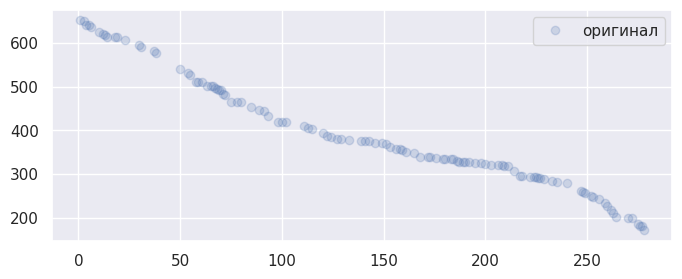

In [5]:
def visualize_column(df, col_name,  df_fixed=None):
    '''Отображает значения одного столбца в указанном столбце.'''
    x = df.index
    plt.plot(x, df[col_name], 'bo', alpha=.2, label='оригинал')
    if df_fixed is not None: plt.plot(x, df_fixed[col_name], 'r-', label='исправлено')
    plt.legend()

visualize_column(df, col_name='lotsize(m^2)')


### Удаление данных
Первая группа методов - методы удаления данных. Мы можем удалить целую строку или целый столбец.

### Удаление строк
На практике это наиболее часто используемый метод обработки отсутствующих значений, потому что его легче всего реализовать. Удаляются все строки, в которых отсутствует хотя бы одно значение.
Проблема заключается в том, что, если есть много строк, которые нужно удалить, то мы теряем много данных (уменьшаем выборку), что может привести к плохой модели.

Чтобы удалить все строки, содержащие хотя бы одно отсутствующее значение, используем метод `dropna()`.

In [6]:
df_fixed = df.dropna()

num_deleted_rows = len(df) - len(df_fixed)
print(num_deleted_rows)

check_for_missing_values(df_fixed)

193


,Количество пропущенных,% пропущенных


### Удаление столбцов
Избавляясь от столбца, содержащего много отсутствующих значений, мы можем упростить и улучшить производительность модели.
Если столбец содержит много отсутствующих значений, вероятно, весь столбец неинформативен, и лучше удалить этот столбец (вместо, например, всех строк).
Если столбец очень информативен (как, например, `lotsize(m^2)`), тогда не рекомендуется удалять столбец, так как это приведет к получению худшей модели, поэтому такой столбец остается в данных.

Для удаления столбца используется метод `drop(columns=[])`.

In [7]:
df_fixed = df.drop(columns=['stories'])

check_for_missing_values(df_fixed)

,Количество пропущенных,% пропущенных
lotsize(m^2),168,60.0


## Заполнение данных
Удаление данных может привести к уменьшению выборки данных и, следовательно, к построению более плохой модели. Вместо того чтобы удалять данные, мы можем заполнить отсутствующие значения (англ. *data imputation*).
Нет универсального наилучшего способа заполнения, потому что это зависит от решаемой задачи.
Хотя мы не знаем, какое конкретное значение должно заменить отсутствующее значение, мы можем сделать оценку.

### Заполнение средним
Чтобы заменить отсутствующие значения средним значением этого столбца, используем метод `fillna()`.

*Примечание: не обязательно использовать среднее значение, иногда медиана или мода дают лучшие результаты.*  
*В данном контексте "мода" (moda) - это значение, которое встречается наиболее часто в наборе данных*

,Количество пропущенных,% пропущенных


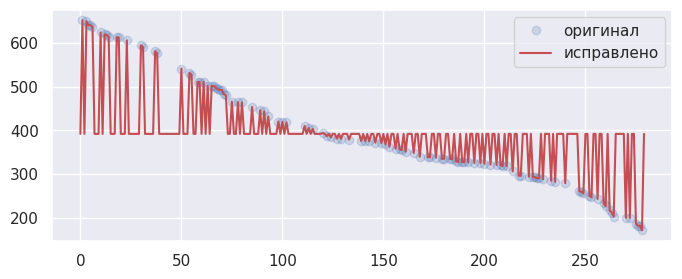

In [8]:
def fillna_mean(df, col_name):
    df_copy = df.copy()
    col_mean = df_copy[col_name].mean()
    df_copy[col_name] = df[col_name].fillna(col_mean)
    return df_copy

df_fixed = fillna_mean(df, 'lotsize(m^2)')
df_fixed = fillna_mean(df_fixed, 'stories')

visualize_column(df, 'lotsize(m^2)', df_fixed)

check_for_missing_values(df_fixed)

### Заполнение полиномом
Интерполяция - это техника, которая находит "скрытую" функцию, наилучшим образом описывающую данные. Интерполяция работает, находя полином, проходящий через точки (данные).

В следующих примерах мы продемонстрируем интерполяцию для площади участка. Аналогично, мы могли бы применить интерполяцию и к колонке `stories`, которая имеет отсутствующие значения.
Пример: интерполяция (и экстраполяция) значений в колонке `lotsize(m^2)` полиномом 1, 3 и 10 степеней. На следующем графике видно, что полином 10 степени лучше всего соответствует данным.

[ 1.36201277e-19 -2.06588079e-16  1.37447127e-13 -5.24196159e-11
  1.25347223e-08 -1.92603092e-06  1.86547639e-04 -1.06217503e-02
  3.08401114e-01 -5.69673230e+00  6.60983480e+02]


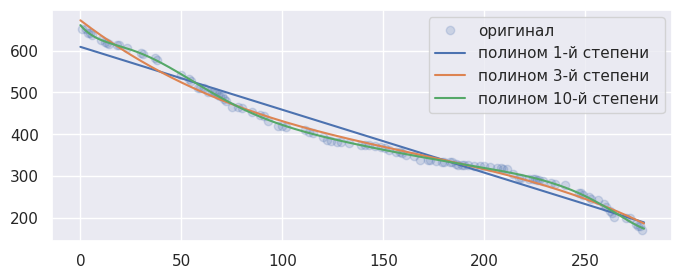

In [14]:
# x и y, которые мы используем, - это значения, которых нет в пропущенных данных
lotsize = df['lotsize(m^2)'].dropna().values
x = df['lotsize(m^2)'].dropna().index.values

# ищем коэффициент полинома
p1 = np.polyfit(x, lotsize, deg=1)
p3 = np.polyfit(x, lotsize, deg=3)
p10 = np.polyfit(x, lotsize, deg=10)

# для каждого x вычисляем y_pred
x = df.index
y1_pred = np.polyval(p1, x)
y3_pred = np.polyval(p3, x)
y10_pred = np.polyval(p10, x)

# визуализация
visualize_column(df, 'lotsize(m^2)')
plt.plot(x, y1_pred, label='полином 1-й степени')
plt.plot(x, y3_pred, label='полином 3-й степени')
plt.plot(x, y10_pred, label='полином 10-й степени')
plt.legend()


### Заполнение сплайном
Вместо того, чтобы искать один полином, описывающий все значения атрибута, мы можем искать полином для частей значений; между каждой парой точек формируем отдельный интерполяционный полином. Такая интерполяция называется интерполяцией сплайном. Результат интерполяции сплайном - не один полином, а набор полиномов.
Мы используем функцию `interpolate()` и определяем параметр `method`. Этот параметр указывает, какой метод интерполяции используется.

#### Линейный сплайн
*Примечание: это не то же самое, что и линейная регрессия.* Предполагает линейную зависимость между двумя соседними значениями $a$ и $c$ и аппроксимирует неизвестное значение $b$ (находится между двумя известными значениями: ...$a$, $b$, $c$...). Между каждой парой точек формируется полином первой степени. Пример: у нас есть 4 данных (a,b,c,d) = (2, NaN, NaN, 5). Мы знаем $a$ и $d$, а интересуют нас значения $b$ и $c$.
```python
a, d = 2, 5
a, b, c, d = interpolated = np.linspace(a, d, num=4) # 2, 3, 4, 5
```

Для линейного сплайна мы используем встроенный метод `interpolate(method='linear', limit_direction='both')`. Второй параметр указывает, что делать экстраполяцию вдоль с обеих сторон от интерполяции, чтобы получить начальные и конечные точки. Обратите внимание, насколько линейный сплайн лучше соответствует данным по сравнению с интерполяционным полиномом.

,Количество пропущенных,% пропущенных
stories,56,20.0


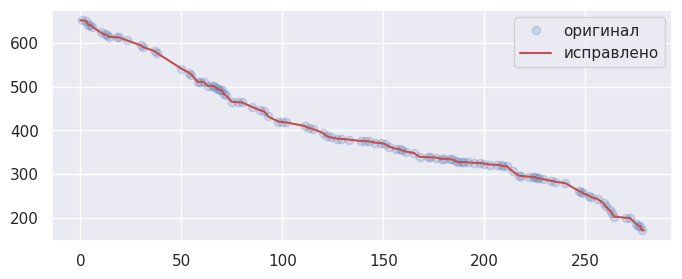

In [10]:
df_fixed = df.copy()
df_fixed['lotsize(m^2)'] = df['lotsize(m^2)'].interpolate(method='linear', limit_direction='both')
visualize_column(df, 'lotsize(m^2)', df_fixed)
check_for_missing_values(df_fixed)

#### Другие сплайны
Линейный сплайн - это очень грубая интерполяция. Переход из одной точки в другую редко линеен. Поэтому часто между двумя точками ищется полином более высокой степени.
Таким образом, переходы между точками не настолько "грубы", как у линейного сплайна.
На практике часто используются сплайны 1, 2 и 3 степени (редко требуется более высокая степень).


,Количество пропущенных,% пропущенных
stories,56,20.0


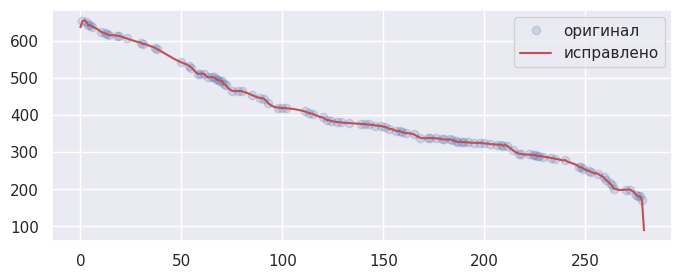

In [11]:
df_fixed = df.copy()
df_fixed['lotsize(m^2)'] = df['lotsize(m^2)'].interpolate(method='spline', order=3, limit_direction='both')
visualize_column(df, 'lotsize(m^2)', df_fixed)
check_for_missing_values(df_fixed)

*Примечание: Экстраполяция сплайном иногда не является хорошей идеей. Посмотрите на правый конец сплайна и заметьте, насколько он плохо соответствует данным. Это происходит потому, что мы экстраполируем последние несколько значений в данных (недостающих последних значений). В такой ситуации было бы лучше использовать один из предыдущих методов, вместо экстраполяции.*

## Итог
#### **Интерполяция**
Интерполяция - это процесс нахождения значений между известными значениями в наборе данных. Это часто используется для заполнения пробелов между точками данных или для создания гладких кривых на основе ограниченного набора измерений.
#### **Экстраполяция**
Экстраполяция - это процесс нахождения значений за пределами диапазона известных данных. Это может быть полезным, когда необходимо предсказать значения вне диапазона известных данных на основе имеющихся данных. Тем не менее, важно понимать, что экстраполяция может быть менее точной и более нестабильной по сравнению с интерполяцией, особенно если экстраполируемые данные находятся далеко от известных данных.

### Тренд в данных
Данные в столбце `lotsize(m^2)` упорядочены в порядке убывания. Что если бы столбец не был упорядочен? Что если бы мы перемешали строки при разделении на обучающий и тестовый наборы данных, а затем применили интерполяцию? Демонстрируем на примере:


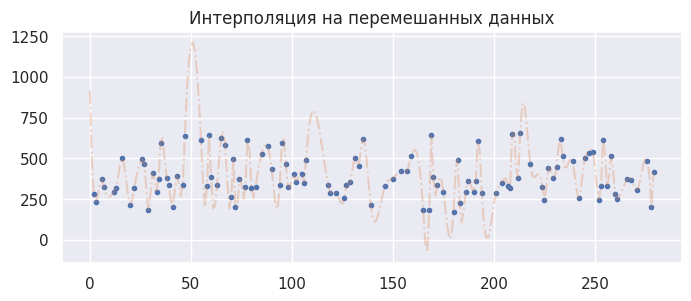

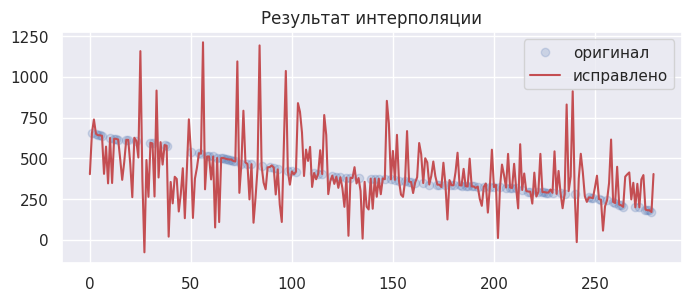

In [13]:
# не обязательно понимать следующий код
# перемешиваем порядок данных в объекте DataFrame
df_fixed2 = shuffle(df, random_state=42).reset_index(drop=False)
# строим график перемешанных данных
plt.plot(df_fixed2['lotsize(m^2)'], '.')
# интерполируем перемешанные данные
df_fixed2['lotsize(m^2)'] = df_fixed2['lotsize(m^2)'].interpolate(method='spline', order=3, limit_direction='both')
# строим график интерполированных значений
plt.plot(df_fixed2['lotsize(m^2)'], '-.', alpha=.3)
plt.title('Интерполяция на перемешанных данных')
plt.show()

# теперь отменяем перемешивание данных (возвращаемся к исходным данным)
df_fixed2 = df_fixed2.sort_values(by='index').reset_index(drop=True).drop(columns='index')
# отображаем результат интерполяции
plt.title('Результат интерполяции')
visualize_column(df, 'lotsize(m^2)', df_fixed2)

С первого графика видно, что результат интерполяции (на перемешанных данных) нашел соответствующий сплайн.
Со второго графика видно, что результат интерполяции не следует тренду в данных по площади участка. 
Можно заключить, что интерполяция на перемешанных данных не дает хороших результатов. Интерполяцию следует использовать до перемешивания данных.

*Совет: когда применяется интерполяция к какой-либо колонне, удостоверьтесь, что существует тренд в данных. Если тренда нет, то интерполяция, как правило, не является хорошим выбором.*

# Задачи
**TODO 1:**
    Создайте регрессионные модели, предсказывающие стоимость дома с использованием пакета `statsmodels` и всех атрибутов. Разделите данные на тренировочный и валидационный наборы в соотношении 70/30. Протестируйте каждую модель, используя настроенную меру $r^2$. Сделайте вывод о том, какая модель лучшая. Модели отличаются способом обработки отсутствующих значений:  
- 1. Удаляет все строки с отсутствующим значением.  
- 2. Удаляет атрибут `stories`, а атрибут `lotsize(m^2)` заполняет средним значением.  
- 3. Заполняет отсутствующие значения кубическим сплайном.  
- 4. Заполняет отсутствующие значения атрибута `stories` линейным сплайном. Остальные отсутствующие значения заполняются квадратным сплайном.  
